In [1]:
# Spark init. / Data Path
from pyspark.sql import SparkSession
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")
review_path = "gs://" + bucket + "/amazon_reviews_2023/silver/reviews_combined_compact"
meta_path = "gs://" + bucket + "/amazon_reviews_2023/silver/meta_combined_compact"
print(review_path)
print(meta_path)

gs://qst843-project/amazon_reviews_2023/silver/reviews_combined_compact
gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact


## Data Setup

In [2]:
# Load Cleaned Data (Review & Meta)
df_reviews = spark.read.option("recursiveFileLookup", "true").parquet(review_path)
df_meta = spark.read.option("recursiveFileLookup", "true").parquet(meta_path)

In [3]:
# Rename / Drop Duplicate Field Names ("title", "category_name")
df_reviews = df_reviews.withColumnRenamed("title", "review_title")
df_meta = df_meta.withColumnRenamed("title", "product_name")
df_meta = df_meta.drop("category_name")

In [4]:
# Check Review Data
df_reviews.printSchema()
df_reviews.show()

root
 |-- user_id: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_image: boolean (nullable = true)
 |-- category_name: string (nullable = true)



+--------------------+-----------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+
|             user_id|parent_asin|          timestamp|rating|        review_title|                text|helpful_vote|verified_purchase|review_image|       category_name|
+--------------------+-----------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+
|AGZPNP4EC4Z7CTHY2...| B07V34XSJ8|2021-05-30 08:51:53|     5|        Comfortable!|    These are great!|           0|             true|       false|Arts_Crafts_and_S...|
|AFOCCQXZYCTLGLQ4Y...| B0047BITNI|2015-03-10 18:23:14|     5|          Five Stars|          very nice.|           0|             true|       false|Arts_Crafts_and_S...|
|AE5XOXRPK5ZCDD2DC...| B08Z7CRNSC|2022-01-17 16:45:32|     5|        Very pleased|  Just what I wanted|           0|             true|       false|Arts_Cra

In [5]:
# Check Meta Data
df_meta.printSchema()
df_meta.show()

root
 |-- parent_asin: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- store: string (nullable = true)
 |-- product_image: boolean (nullable = true)
 |-- product_video: boolean (nullable = true)



+-----------+--------------------+-------------+----------+-----+--------------------+--------------------+--------------+-------------+-----+-------------+-------------+-------------+
|parent_asin|        product_name|main_category|categories|price|            features|         description|average_rating|rating_number|brand|        store|product_image|product_video|
+-----------+--------------------+-------------+----------+-----+--------------------+--------------------+--------------+-------------+-----+-------------+-------------+-------------+
| B01AB5SIXO|NuGene NuEye Eye ...|   All Beauty|        []| NULL|                  []|                  []|           5.0|            1| NULL|         NULL|         true|        false|
| B07DNP5SY9|18INCH #24 Ash Bl...|   All Beauty|        []| NULL|                  []|                  []|           1.0|            1| NULL|     benehair|         true|        false|
| B08F51HG1R|Headbands for Wom...|   All Beauty|        []| NULL|          

In [6]:
# Join Review & Meta Data into a Single df
df = df_reviews.join(
    df_meta,
    on="parent_asin",
    how="left"
)
# Check Joined Data
df.printSchema()
df.show()

root
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_image: boolean (nullable = true)
 |-- category_name: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- store: string (nullable = true)
 |-- produ

+-----------+--------------------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------+-------------+-----+--------------+-------------+-------------+
|parent_asin|             user_id|          timestamp|rating|        review_title|                text|helpful_vote|verified_purchase|review_image|       category_name|        product_name|       main_category|          categories| price|            features|         description|average_rating|rating_number|brand|         store|product_image|product_video|
+-----------+--------------------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--

In [7]:
df.select("category_name").distinct().show(truncate=False)

+---------------------------+
|category_name              |
+---------------------------+
|Patio_Lawn_and_Garden      |
|Cell_Phones_and_Accessories|
|Automotive                 |
|Musical_Instruments        |
|Arts_Crafts_and_Sewing     |
|Grocery_and_Gourmet_Food   |
|Baby_Products              |
|Office_Products            |
|Health_and_Personal_Care   |
|All_Beauty                 |
+---------------------------+



## Prediction Models with ML

### Model 1) Average rating prediction 
- Using **main_category, description_words, price, product_image, product_video**

In [29]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# 1. Data Filtering
df_meta_ml = df_meta.select(
    "main_category",
    "price",
    "average_rating",
    "product_name",
    "product_image",
    "product_video",
    "description"
)

initial_count = df_meta_ml.count()
print(f"1. Initial data count: {initial_count}")

df_meta_ml = df_meta_ml.filter(F.col("price").isNotNull())

df_meta_ml = df_meta_ml.na.drop(
    how='all', 
    subset=["main_category", "product_image", "product_video"]
)

remaining_count = df_meta_ml.count()
print(f"2. Remaining data count after dropping NAs: {remaining_count}")
print(f"   (Dropped rows: {initial_count - remaining_count})")

if remaining_count < 100:
    print("WARNING: Too few data points remaining. Model training might be difficult.")

# 2. Feature Engineering
df_meta_ml = df_meta_ml.withColumn(
    "description_words",
    F.when(F.col("description").isNull(), F.lit(0))
     .otherwise(F.size(F.split(F.concat_ws(" ", F.col("description")), r"\s+")))
)

df_meta_ml = df_meta_ml.withColumn("product_name_clean", F.coalesce(F.col("product_name"), F.lit("")))

df_meta_ml = df_meta_ml.withColumn(
    "name_word_count",
    F.size(F.split(F.trim(F.col("product_name_clean")), r"\s+"))
)
df_meta_ml = df_meta_ml.withColumn(
    "name_word_count",
    F.when(F.col("product_name_clean") == "", 0).otherwise(F.col("name_word_count"))
)

df_meta_ml = df_meta_ml.withColumn(
    "upper_char_count",
    F.length(F.regexp_replace(F.col("product_name_clean"), "[^A-Z]", ""))
)
df_meta_ml = df_meta_ml.withColumn(
    "caps_ratio",
    F.when(F.length(F.col("product_name_clean")) > 0, 
           F.col("upper_char_count") / F.length(F.col("product_name_clean")))
     .otherwise(0.0)
)

df_meta_ml = df_meta_ml.withColumn(
    "has_special_chars",
    F.when(F.col("product_name_clean").rlike(r"[^a-zA-Z0-9\s]"), 1).otherwise(0)
)

# 3. Cleaning & Type Casting
df_meta_ml = df_meta_ml.drop("description", "product_name", "product_name_clean", "upper_char_count")

df_meta_ml_clean = df_meta_ml.fillna({
    "main_category": "Unknown",
    "product_image": False,
    "product_video": False,
    "caps_ratio": 0.0
})

df_meta_ml_clean = (
    df_meta_ml_clean
    .withColumn("product_image_int", F.col("product_image").cast("int"))
    .withColumn("product_video_int", F.col("product_video").cast("int"))
)

# 4. ML Pipeline
indexer = StringIndexer(inputCol="main_category", outputCol="main_category_idx", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="main_category_idx", outputCol="main_category_vec")

assembler = VectorAssembler(
    inputCols=[
        "price",              
        "name_word_count",    
        "caps_ratio",         
        "has_special_chars",  
        "product_image_int",  
        "product_video_int",  
        "description_words",  
        "main_category_vec"   
    ],
    outputCol="features"
)

rf = RandomForestRegressor(
    labelCol="average_rating",
    featuresCol="features",
    numTrees=150,
    maxDepth=10,
    seed=42
)

pipeline = Pipeline(stages=[indexer, encoder, assembler, rf])

# 5. Model Train & Evaluation
train, test = df_meta_ml_clean.randomSplit([0.7, 0.3], seed=42)

model = pipeline.fit(train)
pred = model.transform(test)

evaluator_rmse = RegressionEvaluator(labelCol="average_rating", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="average_rating", predictionCol="prediction", metricName="r2")

print(f"RMSE: {evaluator_rmse.evaluate(pred)}")
print(f"R2: {evaluator_r2.evaluate(pred)}")

# 6. Feature Importance
rf_model = model.stages[-1]
importances = rf_model.featureImportances.toArray()

numeric_features = [
    "price", 
    "name_word_count", 
    "caps_ratio", 
    "has_special_chars", 
    "product_image_int", 
    "product_video_int", 
    "description_words"
]

print("\n[Feature Importance]")
for i, name in enumerate(numeric_features):
    print(f"{name}: {importances[i]:.4f}")

1. Initial data count: 5244716


2. Remaining data count after dropping NAs: 1926217
   (Dropped rows: 3318499)


25/12/09 04:50:50 WARN DAGScheduler: Broadcasting large task binary with size 1635.0 KiB
25/12/09 04:51:02 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/12/09 04:51:16 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
25/12/09 04:51:31 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB
25/12/09 04:51:33 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
25/12/09 04:51:50 WARN DAGScheduler: Broadcasting large task binary with size 2019.3 KiB
25/12/09 04:51:52 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
25/12/09 04:52:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


RMSE: 0.6747654865555409


R2: 0.03066360193225315

[Feature Importance]
price: 0.0845
name_word_count: 0.0673
caps_ratio: 0.0342
has_special_chars: 0.0100
product_image_int: 0.0000
product_video_int: 0.1661
description_words: 0.0991


In [30]:
import pandas as pd

# 1. Extract objects from the model for main_category
indexer_model = model.stages[0]
rf_model = model.stages[-1]

# 2. Get importance vector
all_importances = rf_model.featureImportances.toArray()

# 3. Process Numeric Features
numeric_features = [
    "price", 
    "name_word_count", 
    "caps_ratio", 
    "has_special_chars", 
    "product_image_int", 
    "product_video_int", 
    "description_words"
]
num_count = len(numeric_features)

features_list = []
for i in range(num_count):
    features_list.append({
        "Feature": numeric_features[i], 
        "Type": "Numeric", 
        "Importance": all_importances[i]
    })

# 4. Process main_category
cat_labels = indexer_model.labels 
cat_importances_vec = all_importances[num_count:]

for i, score in enumerate(cat_importances_vec):
    if i < len(cat_labels):
        label_name = f"Category: {cat_labels[i]}"
        features_list.append({
            "Feature": label_name, 
            "Type": "Category", 
            "Importance": score
        })

# 5. Create df and sort
df_importance = pd.DataFrame(features_list)
df_importance = df_importance.sort_values("Importance", ascending=False).reset_index(drop=True)

# 6. Print Results
print(f"Total Feature Count: {len(df_importance)}")
print("-" * 50)
print(df_importance.head(20))

Total Feature Count: 49
--------------------------------------------------
                                Feature      Type  Importance
0   Category: Cell Phones & Accessories  Category    0.219645
1                     product_video_int   Numeric    0.166122
2                     description_words   Numeric    0.099114
3                                 price   Numeric    0.084511
4             Category: Office Products  Category    0.082467
5             Category: All Electronics  Category    0.079553
6                       name_word_count   Numeric    0.067262
7       Category: Arts, Crafts & Sewing  Category    0.049211
8                            caps_ratio   Numeric    0.034154
9     Category: Collectibles & Fine Art  Category    0.031579
10                Category: Amazon Home  Category    0.021760
11               Category: Toys & Games  Category    0.015584
12                    has_special_chars   Numeric    0.010047
13          Category: Collectible Coins  Category    0.00

/tmp/ipykernel_18118/163431038.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


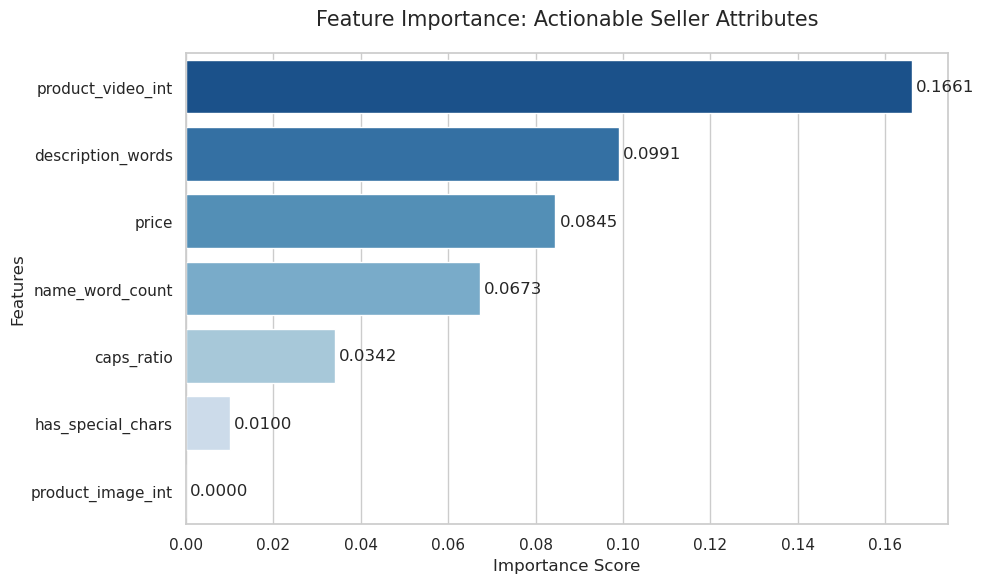

/tmp/ipykernel_18118/163431038.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


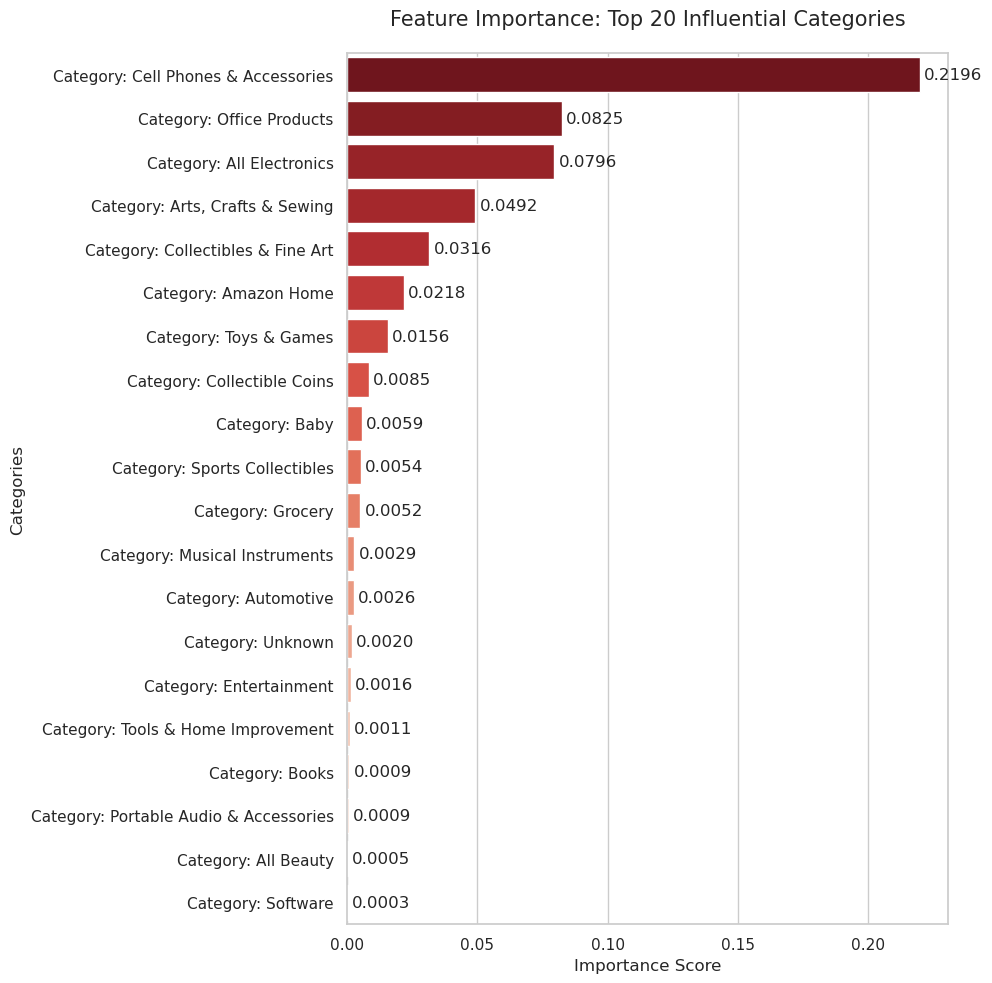

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Separate DataFrames
df_numeric = df_importance[df_importance['Type'] == 'Numeric'].copy()
df_category = df_importance[df_importance['Type'] == 'Category'].copy()

# Sort by Importance
df_numeric = df_numeric.sort_values("Importance", ascending=False)
df_category = df_category.sort_values("Importance", ascending=False).head(20)

# Set plot style
sns.set_theme(style="whitegrid")

# Chart 1: Numeric Features (Actionable)
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(
    x="Importance", 
    y="Feature", 
    data=df_numeric, 
    palette="Blues_r"
)

plt.title("Feature Importance: Actionable Seller Attributes", fontsize=15, pad=20)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

# Chart 2: Category Features (Top 20 Impact)
plt.figure(figsize=(10, 10))
ax2 = sns.barplot(
    x="Importance", 
    y="Feature", 
    data=df_category, 
    palette="Reds_r"
)

plt.title("Feature Importance: Top 20 Influential Categories", fontsize=15, pad=20)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Categories", fontsize=12)

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

#### Summary
Unfortunately, with the current dataset, it was difficult to build a more accurate prediction model. However, the insights obtained from the machine learning process—such as the feature importance results—were still highly valuable and actionable.

### Feature Importance Analysis

#### 1. Product Video
Product videos have the strongest influence on ratings, while images contribute very little.  
**Recommendation:** Invest in at least one high-quality product video.

#### 2. Detailed Descriptions
Longer and more thorough descriptions are associated with higher ratings.  
**Recommendation:** Write clear and detailed product descriptions.

#### 3. Price
Price has only moderate impact on ratings, likely due to differing expectations across categories.

#### 4. Title Tricks Don’t Work
Title length, ALL CAPS, and special characters show minimal effect on ratings.  
**Recommendation:** Keep titles clean and keyword-focused.


### Main Product Category Importance
#### 1. “Cell Phones & Accessories” is by far the most influential category in predicting product ratings.
It appears as the longest bar in the chart.
This means that products in this category show **large variability in ratings** and **high diversity in customer complaints**, making the category extremely important for the model when predicting ratings.\
In other words: **“The cell phone accessories market has highly inconsistent and unpredictable ratings.”**

#### 2. Office Products, Electronics, Arts & Crafts, and similar categories follow in importance.
These categories also show distinctive rating patterns, so the model uses them as helpful signals when estimating a product's rating.

#### 3. Categories toward the bottom contribute very little to rating prediction.
Examples: All Beauty, Software, Books.

This indicates that these categories have **more stable ratings** and **smaller differences between products**, meaning the model does not rely heavily on category information for them.

### Model 2) Negative Review NLP Analysis
- Using **text(review texts), rating**

In [26]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
import pandas as pd

# 0. Data Preparation
# Select necessary columns
df_for_ml = df.select("rating", "text")

# Filter for negative reviews (Extracting Negative Review - 1 & 2 star ratings)
df_neg = df_for_ml.filter(
    F.col("rating").isin([1, 2]) & 
    F.col("text").isNotNull()
)

# 1. Text Cleaning

# 1) Convert to lowercase
df_neg_clean = df_neg.withColumn("text_clean", lower(col("text")))

# 2) Remove HTML tags and URLs
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "<[^>]+>", " ")) 
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "http\\S+", "")) 

# 3) Expand English contractions - Some frequently used unimportant words
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "won't", "will not"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "can't", "can not"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "n't", " not"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "'ll", " will"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "'re", " are"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "'ve", " have"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "'m", " am"))

# 4) Remove numbers and punctuations
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "[^a-z\\s]", ""))

# 5) Remove noise - short words (1-2 characters) & extra whitespace
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "\\b[a-z]{1,2}\\b", ""))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "\\s+", " "))
df_neg_clean = df_neg_clean.withColumn("text_clean", F.trim(col("text_clean")))

# 2. Define Stopwords (English + Custom + Spanish)

# A. General words that hinder analysis
custom_stops = [
    "product", "item", "one", "get", "use", "used", "using", 
    "buy", "bought", "buying", "purchase", "purchased", "ordered", "order",
    "came", "got", "sent", "work", "worked", "working", "works", "job",
    "good", "great", "even", "like", "really", "much", "well", "look", "looks",
    "amazon", "seller", "customer", "service", "review",
    "try", "tried", "put", "back", "way", "made", "make", "think", "know", "say", "said",
    "thing", "things", "stuff", "lot", "another", "feature", "issue", "problem"
]

# B. Spanish stopwords (to remove noise)
spanish_stops = [
    "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las", "por", 
    "un", "para", "con", "no", "una", "su", "al", "lo", "como", "mas", "pero", 
    "sus", "le", "ya", "o", "este", "si", "porque", "esta", "entre", "cuando", 
    "muy", "sin", "sobre", "tambien", "me", "hasta", "hay", "donde", "quien", 
    "desde", "todo", "nos", "durante", "todos", "uno", "les", "ni", "contra", 
    "otros", "ese", "eso", "ante", "ellos", "e", "esto", "mia", "otro", "el",
    "es", "son", "fue"
]

# Combine all stopword lists
final_stop_words = StopWordsRemover.loadDefaultStopWords("english") + custom_stops + spanish_stops

# 3. Build ML Pipeline

# 1) Tokenizer
tokenizer = Tokenizer(inputCol="text_clean", outputCol="tokens")

# 2) StopWordsRemover
remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens",
    stopWords=final_stop_words
)

# 3) CountVectorizer
cv = CountVectorizer(
    inputCol="filtered_tokens",
    outputCol="cv_features",
    vocabSize=10000, 
    minDF=10         
)

# 4) LDA Model
num_topics = 30
lda = LDA(
    k=num_topics,          
    maxIter=50,            
    featuresCol="cv_features",
    seed=42
)

pipeline_neg = Pipeline(stages=[tokenizer, remover, cv, lda])

# 4. Train Model and Extract Results
print("Training LDA model with 30 topics (Cleaned Data)...")
model_neg = pipeline_neg.fit(df_neg_clean)

# Get Vocabulary
cv_model = model_neg.stages[2]
vocab = cv_model.vocabulary

# Get LDA Model
lda_model = model_neg.stages[3]
topics = lda_model.describeTopics(10) # Top 10 words per topic

# 5. Convert to Pandas DataFrame and Print
topics_rdd = topics.rdd.map(lambda row: row['termIndices']).collect()
topic_weights_rdd = topics.rdd.map(lambda row: row['termWeights']).collect()

topic_data = []
for i in range(len(topics_rdd)):
    words = [vocab[idx] for idx in topics_rdd[i]]
    words_str = ", ".join(words)
    topic_data.append({"Topic_ID": i, "Keywords": words_str})

df_topics = pd.DataFrame(topic_data)

# Display settings
pd.set_option('display.max_colwidth', None)

print("LDA Topic Modeling Result (Negative Reviews)")
print(df_topics)

Training LDA model with 30 topics (Cleaned Data)...


LDA Topic Modeling Result (Negative Reviews)
    Topic_ID  \
0          0   
1          1   
2          2   
3          3   
4          4   
5          5   
6          6   
7          7   
8          8   
9          9   
10        10   
11        11   
12        12   
13        13   
14        14   
15        15   
16        16   
17        17   
18        18   
19        19   
20        20   
21        21   
22        22   
23        23   
24        24   
25        25   
26        26   
27        27   
28        28   
29        29   

                                                                                         Keywords  
0                         light, months, year, unit, lights, warranty, last, lasted, new, stopped  
1                  case, phone, cover, iphone, fit, dropped, protect, screen, plastic, protection  
2                    charge, battery, charger, charging, phone, power, cord, cable, charged, plug  
3                           cheap, worth, money, price, be

In [28]:
# Mapping Dictionary (Topic_ID -> English Label)
topic_name_map = {
    # Group 1: Tech & Functionality
    2: "Charging/Battery Failure",
    9: "Printer/Ink Incompatibility",
    12: "Audio/Hardware Failure",
    24: "Sim Card/Connectivity",
    26: "Instructions/Missing Parts",
    29: "Cable/Accessory Failure",

    # Group 2: Durability & Quality
    0: "Stopped Working (Short Life)",
    3: "Poor Value (Junk)",
    17: "Broke Within Weeks",
    19: "Poor Material (Flimsy Plastic)",
    20: "Adhesion Failure (Won't Stick)",
    29: "General Dissatisfaction",
    
    # Group 3: Fitment & Assembly
    1: "Phone Case Fitment",
    12: "Assembly/Screw Alignment",
    15: "Car Seat/Holder Fit",
    16: "Screen Protector Bubbles/Crack",
    21: "Vehicle Model Incompatibility",
    27: "Sizing Issues (Too Small)",

    # Group 4: Shipping, Service & Description
    10: "Return Window Issues",
    11: "Refund/Service Issues",
    14: "Arrived Damaged/Opened",
    22: "Description/Color Mismatch",
    
    # Group 5: Food & Taste
    8: "Water/Feeder Leakage",
    23: "Stale/Bad Taste (Food)",
    28: "Beverage Flavor Issues",

    # Group 6: Specific Niche
    4: "Art/Office Supplies Quality",
    5: "Hair/Beauty Product Quality",
    6: "Cutting Tools/Blades",
    7: "Pens Dried Out",
    13: "Plants/Gardening Damage",
    25: "Wearables/Watch Bands"
}

# Apply the mapping
df_topics['Topic_Category'] = df_topics['Topic_ID'].map(topic_name_map)
df_topics['Topic_Category'] = df_topics['Topic_Category'].fillna("Other Issues")

# Display Final Table
print(df_topics[['Topic_Category', 'Keywords', 'Topic_ID']])

                    Topic_Category  \
0     Stopped Working (Short Life)   
1               Phone Case Fitment   
2         Charging/Battery Failure   
3                Poor Value (Junk)   
4      Art/Office Supplies Quality   
5      Hair/Beauty Product Quality   
6             Cutting Tools/Blades   
7                   Pens Dried Out   
8             Water/Feeder Leakage   
9      Printer/Ink Incompatibility   
10            Return Window Issues   
11           Refund/Service Issues   
12        Assembly/Screw Alignment   
13         Plants/Gardening Damage   
14          Arrived Damaged/Opened   
15             Car Seat/Holder Fit   
16  Screen Protector Bubbles/Crack   
17              Broke Within Weeks   
18                    Other Issues   
19  Poor Material (Flimsy Plastic)   
20  Adhesion Failure (Won't Stick)   
21   Vehicle Model Incompatibility   
22      Description/Color Mismatch   
23          Stale/Bad Taste (Food)   
24           Sim Card/Connectivity   
25          

## Negative Review Topic Grouping (Root Cause Analysis)

### **Group A. Tech & Functionality**  
This represents the most specific and critical functional failures.

#### **Topic 2 — Charging/Power**
- **Keywords:** charge, battery, cord, plug  
- **Meaning:** Charging failure or poor cable contact.

#### **Topic 9 — Printer**
- **Keywords:** printer, ink, cartridge, printing  
- **Meaning:** Ink recognition failure, poor print quality.

#### **Topic 16 — Screen Protection**
- **Keywords:** screen, protector, bubbles, edges  
- **Meaning:** Bubbles appearing, edges lifting.

#### **Topic 18 — Audio/Buttons**
- **Keywords:** sound, volume, hear, buttons  
- **Meaning:** No sound or button malfunction.

#### **Topic 24 — Connectivity/SIM**
- **Keywords:** card, sim, phone, call  
- **Meaning:** SIM card recognition failure, call connection issues.

---

### **Group B. Durability & Quality**  
This group is closely associated with reviews mentioning *“waste of money”* and severe quality issues.

#### **Topic 17 — Early Breakage**
- **Keywords:** broke, apart, fell, weeks  
- **Meaning:** Broke apart within weeks of purchase.

#### **Topic 19 — Poor Material**
- **Keywords:** plastic, cheap, flimsy, metal  
- **Meaning:** “Thought it was metal, but it's cheap plastic.”

#### **Topic 0 — Short Lifespan**
- **Keywords:** stopped, months, warranty, lasted  
- **Meaning:** Stopped working immediately after the warranty expired.

#### **Topic 3 & 29 — Emotional Venting**
- **Keywords:** junk, waste, money, garbage  
- **Meaning:** Emotional frustration rather than a specific technical fault.

---

### **Group C. Assembly & Installation**  
Common in items requiring user assembly or installation.

#### **Topic 12 — Screws/Assembly**
- **Keywords:** holes, screws, install, bolts  
- **Meaning:** Screw holes do not align; assembly impossible.

#### **Topic 20 — Adhesion Problems**
- **Keywords:** stick, adhesive, fall, wall  
- **Meaning:** Item fails to adhere properly; falls off immediately.

#### **Topic 26 — Manuals/Parts**
- **Keywords:** instructions, missing, parts, wrong  
- **Meaning:** Missing instructions or missing parts.

---

### **Group D. Shipping & Misleading**  
Issues related to logistics or misleading product information.

#### **Topic 14 — Damaged Arrival**
- **Keywords:** box, broken, opened, smell  
- **Meaning:** Package arrived torn, broken, or with odor.

#### **Topic 22 — Description Mismatch**
- **Keywords:** picture, color, description, nothing  
- **Meaning:** Product looks completely different from photos or color.

#### **Topic 10 & 11 — Returns/Refunds**
- **Keywords:** return, refund, days, company  
- **Meaning:** Difficult return process or delayed refunds.

---

### **Group E. Domain-Specific Complaints**  
Issues unique to particular product categories.

#### **Topic 23 & 28 — Food/Taste**
- **Keywords:** taste, flavor, stale, coffee, candy  
- **Meaning:** Stale, tasteless, or old food products.

#### **Topic 8 — Water/Pets**
- **Keywords:** water, pool, feeder, suction  
- **Meaning:** Pet feeder or pool pump malfunction.

#### **Topic 7 — Stationery**
- **Keywords:** pen, ink, write, dry  
- **Meaning:** Pen ink dried out; doesn’t write.

#### **Topic 13 — Plants/Gardening**
- **Keywords:** plants, dead, cracked  
- **Meaning:** Plants arrived dead; pots cracked.

---

### **Group F. Fitment & Sizing**  
Common in accessories, covers, and vehicle-related items.

#### **Topic 1 — Phone Case Fitment**
- **Keywords:** case, fit, dropped, protect  
- **Meaning:** Phone case does not fit the device.

#### **Topic 15 & 21 — Vehicle Accessories**
- **Keywords:** car, seat, truck, fit  
- **Meaning:** Does not fit the specific vehicle model.

#### **Topic 27 — Cover Sizing**
- **Keywords:** small, size, rain, cover  
- **Meaning:** Cover size is too small.


#### Summary 
This analysis was conducted using our entire dataset. However, if sellers narrow the scope of the data—by filtering based on their own product group (such as by parent_asin or store)—they can perform the same analysis in a more targeted way. This would enable them to categorize and understand the specific types of customer complaints that are most relevant to their products, making the insights even more useful.

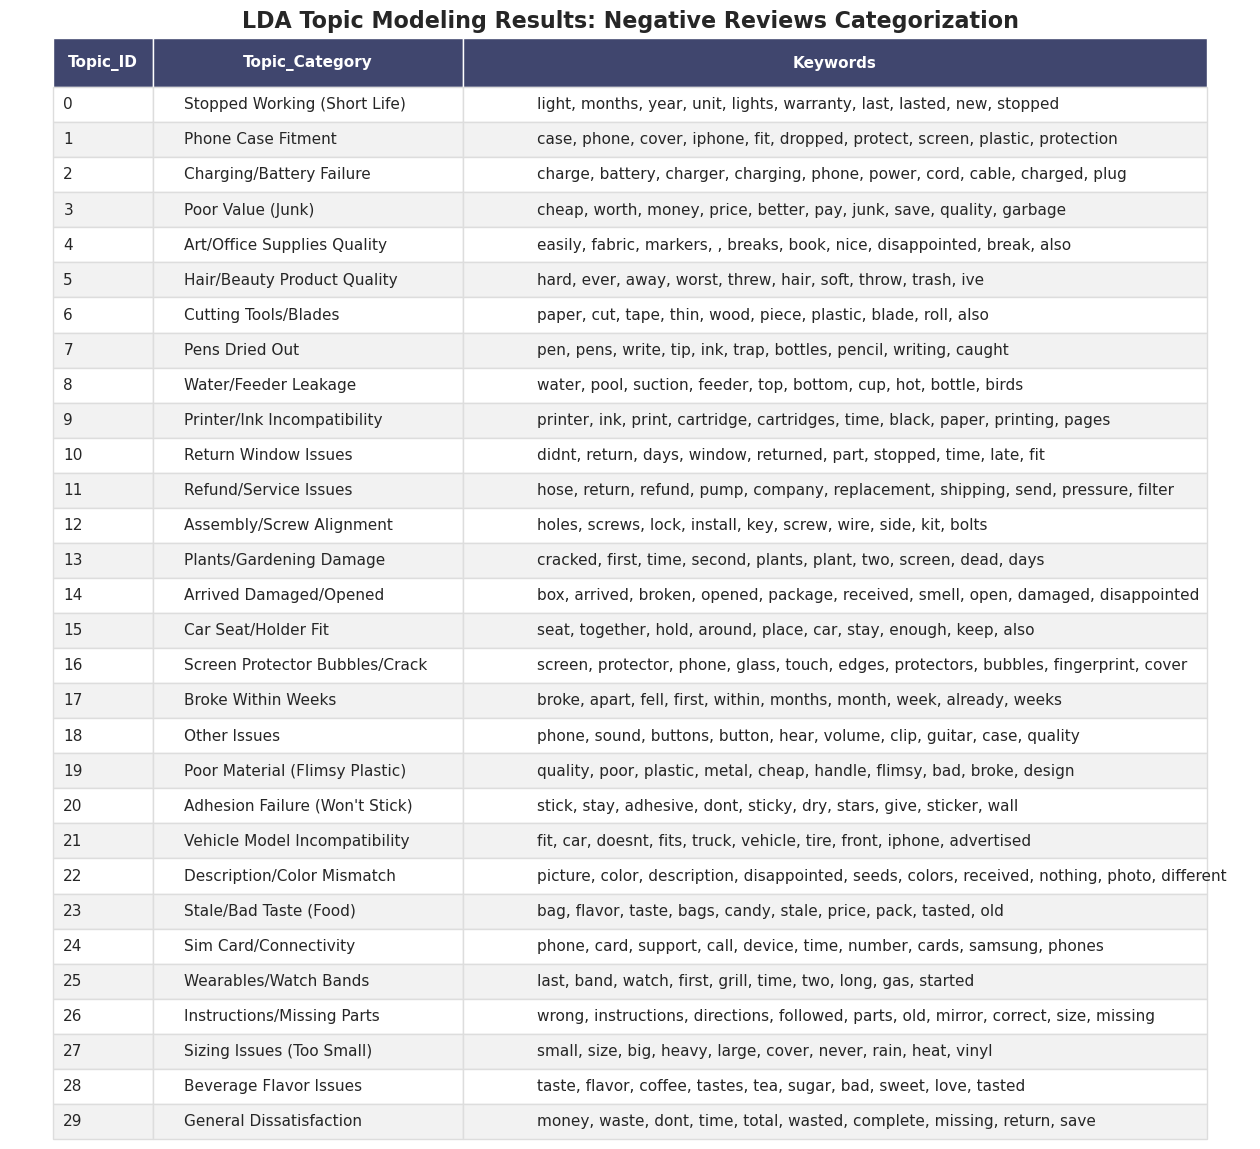

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import table

# 1. 데이터 정의 (그대로 유지)
data = {
    'Topic_ID': list(range(30)),
    'Topic_Category': [
        "Stopped Working (Short Life)", "Phone Case Fitment", "Charging/Battery Failure", "Poor Value (Junk)",
        "Art/Office Supplies Quality", "Hair/Beauty Product Quality", "Cutting Tools/Blades", "Pens Dried Out",
        "Water/Feeder Leakage", "Printer/Ink Incompatibility", "Return Window Issues", "Refund/Service Issues",
        "Assembly/Screw Alignment", "Plants/Gardening Damage", "Arrived Damaged/Opened", "Car Seat/Holder Fit",
        "Screen Protector Bubbles/Crack", "Broke Within Weeks", "Other Issues", "Poor Material (Flimsy Plastic)",
        "Adhesion Failure (Won't Stick)", "Vehicle Model Incompatibility", "Description/Color Mismatch",
        "Stale/Bad Taste (Food)", "Sim Card/Connectivity", "Wearables/Watch Bands", "Instructions/Missing Parts",
        "Sizing Issues (Too Small)", "Beverage Flavor Issues", "General Dissatisfaction"
    ],
    'Keywords': [
        "light, months, year, unit, lights, warranty, last, lasted, new, stopped",
        "case, phone, cover, iphone, fit, dropped, protect, screen, plastic, protection",
        "charge, battery, charger, charging, phone, power, cord, cable, charged, plug",
        "cheap, worth, money, price, better, pay, junk, save, quality, garbage",
        "easily, fabric, markers, , breaks, book, nice, disappointed, break, also",
        "hard, ever, away, worst, threw, hair, soft, throw, trash, ive",
        "paper, cut, tape, thin, wood, piece, plastic, blade, roll, also",
        "pen, pens, write, tip, ink, trap, bottles, pencil, writing, caught",
        "water, pool, suction, feeder, top, bottom, cup, hot, bottle, birds",
        "printer, ink, print, cartridge, cartridges, time, black, paper, printing, pages",
        "didnt, return, days, window, returned, part, stopped, time, late, fit",
        "hose, return, refund, pump, company, replacement, shipping, send, pressure, filter",
        "holes, screws, lock, install, key, screw, wire, side, kit, bolts",
        "cracked, first, time, second, plants, plant, two, screen, dead, days",
        "box, arrived, broken, opened, package, received, smell, open, damaged, disappointed",
        "seat, together, hold, around, place, car, stay, enough, keep, also",
        "screen, protector, phone, glass, touch, edges, protectors, bubbles, fingerprint, cover",
        "broke, apart, fell, first, within, months, month, week, already, weeks",
        "phone, sound, buttons, button, hear, volume, clip, guitar, case, quality",
        "quality, poor, plastic, metal, cheap, handle, flimsy, bad, broke, design",
        "stick, stay, adhesive, dont, sticky, dry, stars, give, sticker, wall",
        "fit, car, doesnt, fits, truck, vehicle, tire, front, iphone, advertised",
        "picture, color, description, disappointed, seeds, colors, received, nothing, photo, different",
        "bag, flavor, taste, bags, candy, stale, price, pack, tasted, old",
        "phone, card, support, call, device, time, number, cards, samsung, phones",
        "last, band, watch, first, grill, time, two, long, gas, started",
        "wrong, instructions, directions, followed, parts, old, mirror, correct, size, missing",
        "small, size, big, heavy, large, cover, never, rain, heat, vinyl",
        "taste, flavor, coffee, tastes, tea, sugar, bad, sweet, love, tasted",
        "money, waste, dont, time, total, wasted, complete, missing, return, save"
    ]
}
df = pd.DataFrame(data)
df = df[['Topic_ID', 'Topic_Category', 'Keywords']]

# 2. 시각화 설정
fig, ax = plt.subplots(figsize=(16, 12)) 
ax.axis('off') 

# 3. 테이블 생성
tab = table.table(
    ax,
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='left' 
)

# 4. 스타일링 적용
tab.auto_set_font_size(False)
tab.set_fontsize(11)
tab.scale(1, 2) 

for (row, col), cell in tab.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e') 
        cell.set_edgecolor('white')
        cell.set_height(0.05)
    else:
        cell.set_edgecolor('#dddddd') 
        if row % 2 == 0:
            cell.set_facecolor('#f2f2f2') 
        else:
            cell.set_facecolor('white') 
            
    if col == 0:
        cell.set_width(0.08)
    elif col == 1:
        cell.set_width(0.25)
    elif col == 2:
        cell.set_width(0.6)

# -------------------------------------------------------------
# [핵심 수정 부분] 제목 위치 조정 및 여백 확보
# -------------------------------------------------------------

# 방법 1: subplots_adjust로 상단 여백(top)을 넉넉하게 확보 (가장 확실함)
# top=0.9로 설정하면 전체 높이의 상단 10%를 비워둡니다.
plt.subplots_adjust(top=0.92)

# 방법 2: 제목의 y축 위치(y)를 1.0보다 크게 설정하고, pad를 늘림
plt.title(
    'LDA Topic Modeling Results: Negative Reviews Categorization', 
    fontsize=16, 
    weight='bold', 
    pad=40,     # 제목과 그래프 사이의 간격
    y=1.02      # 제목의 절대적인 y축 위치 (1.0이 차트의 맨 꼭대기)
)

# -------------------------------------------------------------

# 출력
# plt.savefig('lda_topic_summary.png', dpi=300, bbox_inches='tight') # 저장 시에도 잘림 방지됨
plt.show()